In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from gensim import corpora, models
from matplotlib import style
style.use('ggplot')

In [5]:
df = pd.read_csv('data/airplane_crashes_since_1900s.csv')
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


# 1) Data Visualization

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].map(lambda x: x.day)
df['Year'] = df['Date'].map(lambda x: x.year)
df['Month'] = df['Date'].map(lambda x: x.month)

# Crashes per year, hopefully this has been going down
crashes_per_year = Counter(df['Year'])
years = list(crashes_per_year.keys())
crashes_year = list(crashes_per_year.values())

In [9]:
"""
It would be useful if we got it by season since flying could be seasonal
"""
def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

In [11]:
df['Season'] = df['Month'].apply(get_season)
crashes_per_season = Counter(df['Season'])
seasons = list(crashes_per_season.keys())
crashes_season = list(crashes_per_season.values())

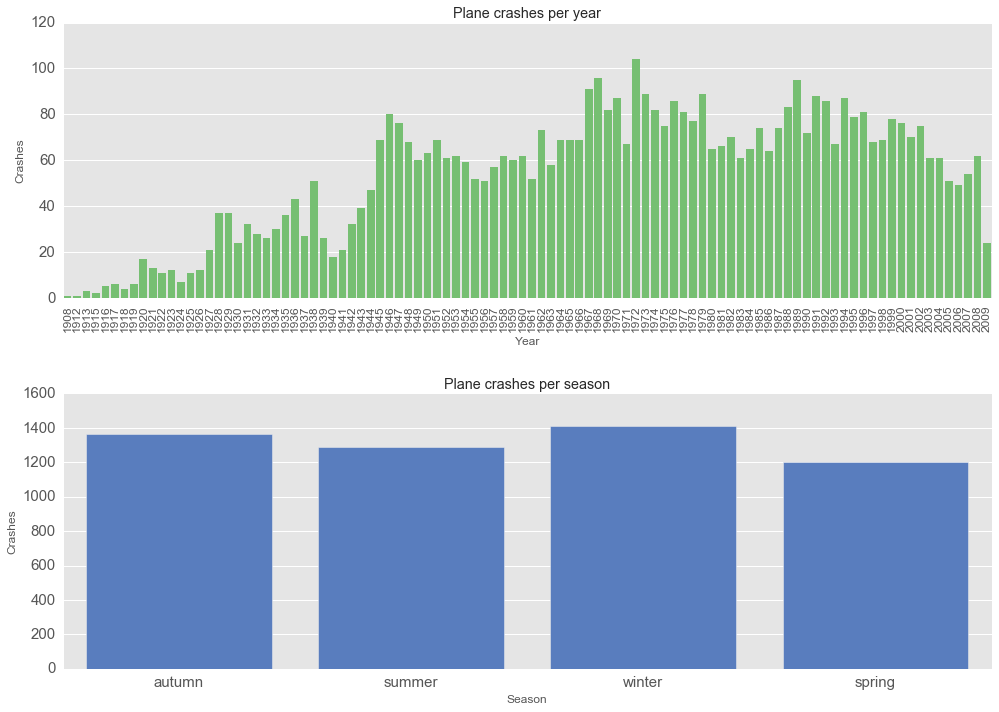

In [37]:
sns.set_color_codes('muted')
fig = plt.figure(figsize=(14, 10))

# Yearly crashes
#sub1 = fig.add_subplot(211)
sns.barplot(x=years, y=crashes_year, color='g', ax=sub1)
sub1.set(ylabel="Crashes", xlabel="Year", title="Plane crashes per year")
plt.setp(sub1.patches, linewidth=0)
plt.setp(sub1.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(sub1.get_yticklabels(), fontsize = 15)

# Seasonal Crashes
sub2 = fig.add_subplot(212)
sns.barplot(x=seasons, y=crashes_season, color='b', ax=sub2)
texts = sub2.set(ylabel="Crashes", xlabel="Season", title="Plane crashes per season")
plt.setp(sub2.get_xticklabels(), fontsize = 15)
plt.setp(sub2.get_yticklabels(), fontsize = 15)

plt.tight_layout(w_pad=4, h_pad=3)

### Conclusion:
I would assume there to be more accidents during the summer because maybe people take up recreational flying. However, that is just something I thought of. 

The truth would probably be that autumn and winter have weathers that are not suitable for flying. Especially if the planes back then were not able to withstand such weather. There could also be more clouds in the sky and planes breaking because of turbulence. We can research more on why planes are destroyed and under what flying conditions in another project. I'm sure the engineers would love to know about the more recent planes, so its not useful here.

## 1.1 Survival and Deaths

In [32]:
survived = []
dead = []

for year in years:
    curr_data = df[df['Year'] == year]
    survived.append(curr_data['Aboard'].sum() - curr_data['Fatalities'].sum())
    dead.append(curr_data['Fatalities'].sum())

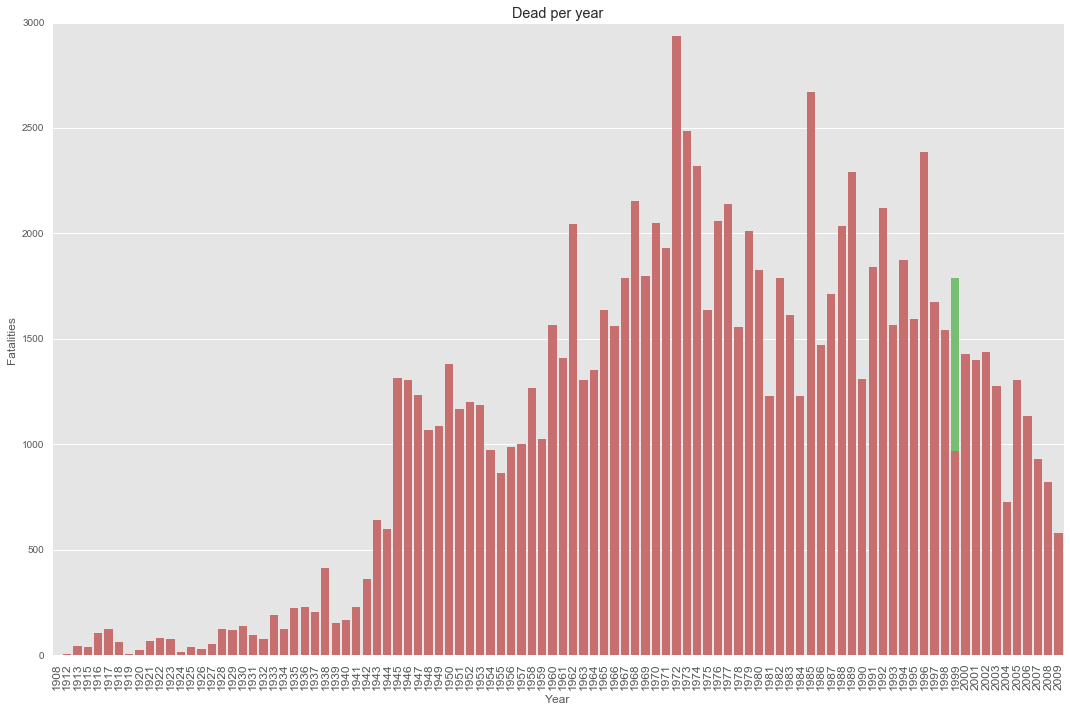

In [66]:
"""
I would plot the bars side by side, but there is no real room for that sadly.
I could export it, but I just wanted this to show there are usually more deaths than survivals.
"""

f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=years, y=survived, color='g', ax=ax)
ax.set(ylabel="Survived", xlabel="Year", title="Survived per year")

sns.barplot(x=years, y=dead, color='r', ax=ax)
ax.set(ylabel="Fatalities", xlabel="Year", title="Dead per year")
plt.setp(ax.patches, linewidth=0)
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=12)

plt.tight_layout(w_pad=4, h_pad=3)

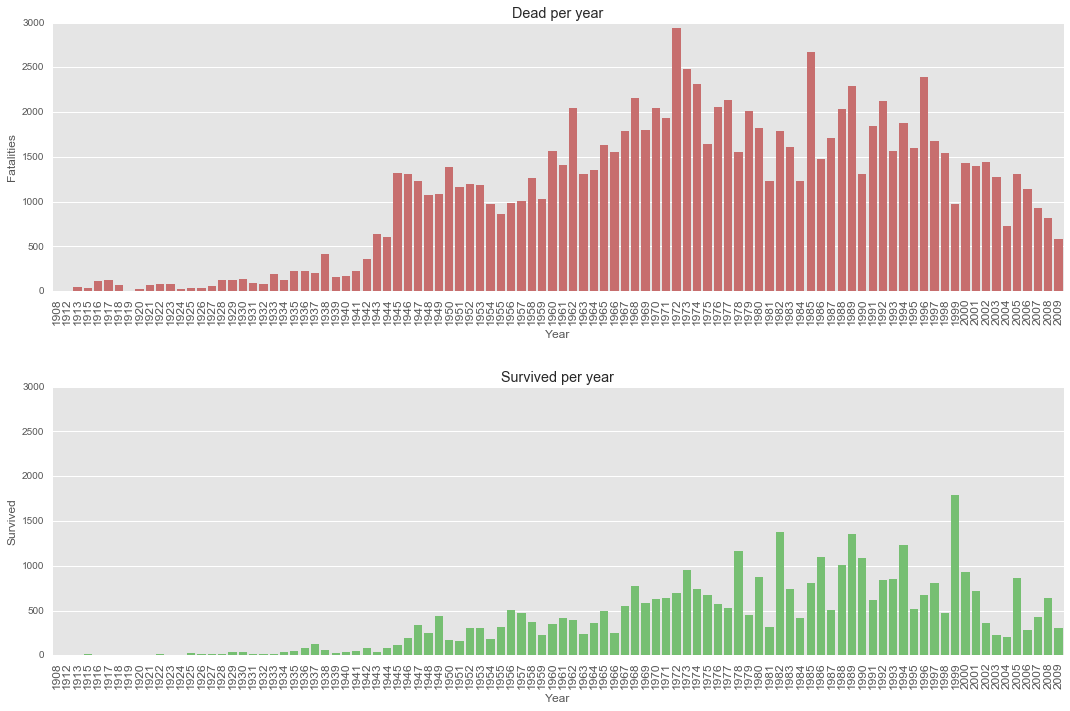

In [68]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharey = True)

sns.barplot(x=years, y=dead, color='r', ax=axes[0])
axes[0].set(ylabel="Fatalities", xlabel="Year", title="Dead per year")
plt.setp(axes[0].patches, linewidth=0)
plt.setp(axes[0].get_xticklabels(), rotation=90, fontsize=12)

sns.barplot(x=years, y=survived, color='g', ax=axes[1])
axes[1].set(ylabel="Survived", xlabel="Year", title="Survived per year")
plt.setp(axes[1].patches, linewidth=0)
plt.setp(axes[1].get_xticklabels(), rotation=90, fontsize=12)


plt.tight_layout(w_pad=4, h_pad=3)

### 1.1.1 Conclusion:
Looks like there were a lot more deaths than people that lived from these accidents. After making the two graphs the same scale because I can't fit both side by side in one graph, we notice the big proportion of deaths to survival rates over the years. Perhaps we could figure out what year planes were finally established as viable and take off the left tail points. However, there is no real cut off year. 

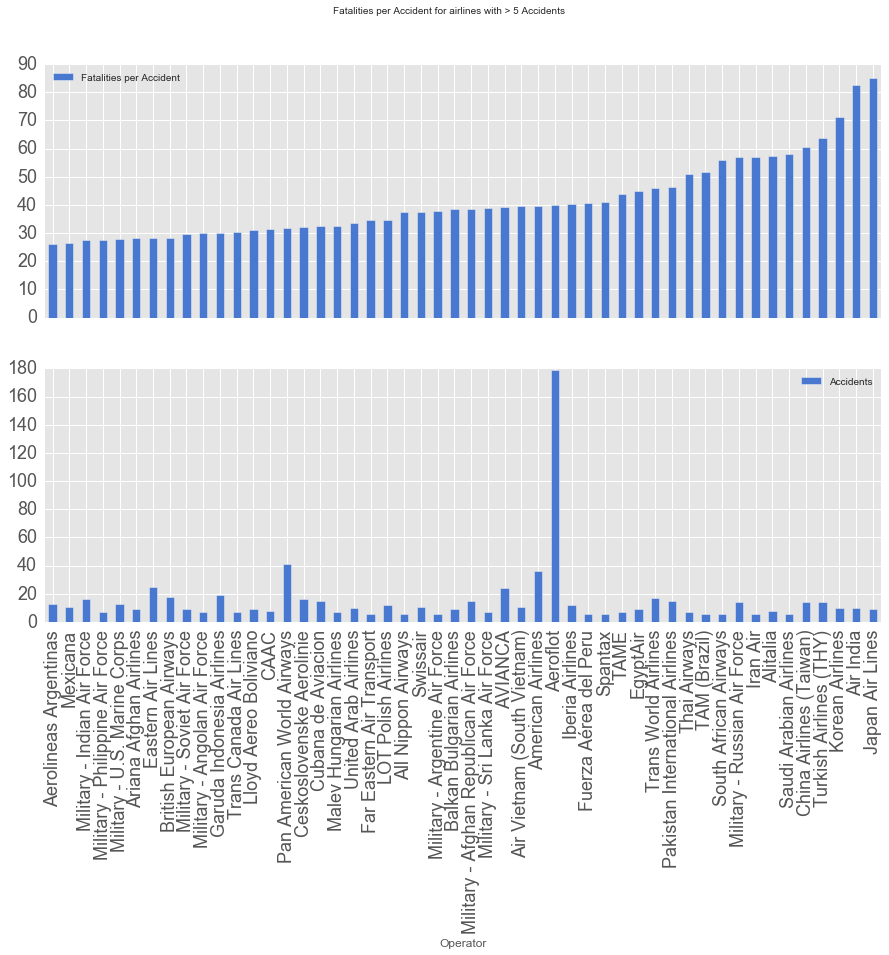

In [72]:
operator = df[['Operator','Fatalities']].groupby('Operator').agg(['sum','count'])

props = operator['Fatalities'].reset_index()
props['Fatalities per Crash'] = props['sum']/props['count']
props.columns = ['Operator',
                 'Fatalities',
                 'Accidents',
                 'Fatalities per Accident']

# We want places that had more than 5 accidents.
fig_p,(axp1,axp2) = plt.subplots(2,1,sharex = True,figsize = (15,10))
fig_p.suptitle('Fatalities per Accident for airlines with > 5 Accidents')

propstoplot = props[props['Accidents']>5]

# Fatalities per Accident
(propstoplot.sort_values('Fatalities per Accident')
            .tail(50)
            .plot(x = 'Operator',
                  y = 'Fatalities per Accident', 
                  ax = axp1,
                  kind = 'bar',
                  color =  'b',
                  grid = True,
                  fontsize = 18))

# Accidents
(propstoplot.sort_values('Fatalities per Accident')
            .tail(50)
            .plot(x = 'Operator', 
                  y = 'Accidents',
                  ax = axp2, 
                  kind = 'bar',
                  color = 'b',
                  grid = True,
                  fontsize = 18))

plt.show()

### 1.1.2 Conclusion:
While Aeroflot had the most accidents, it has less fatalities per accident than the airlines to the right of it. 

Doesn't mean it has the least Fatalities though. We can multiple Fatalities per accident with the number of accidents. However, that isn't necessary because the table already has that. We can see the preview down below.

In [78]:
propstoplot[['Operator','Fatalities']].head()

,Operator,Fatalities
22,AVIANCA,941.0
84,Aeroflot,7156.0
97,Aerolineas Argentinas,341.0
125,Aeropostale,52.0
168,Air America,116.0


## 1.2 The Worst Operators and Locations to Fly To/Out

In [81]:
oper_list = Counter(df['Operator']).most_common(12)
operators = []
crashes = []

for tpl in oper_list:
    if 'Military' not in tpl[0]:
        operators.append(tpl[0])
        crashes.append(tpl[1])
print('Top 10 the worst operators')
pd.DataFrame({'Count of crashes' : crashes}, index=operators)

Top 10 the worst operators


,Count of crashes
Aeroflot,179
Air France,70
Deutsche Lufthansa,65
Air Taxi,44
China National Aviation Corporation,44
United Air Lines,44
Pan American World Airways,41
US Aerial Mail Service,36
American Airlines,36


In [82]:
loc_list = Counter(df['Location'].dropna()).most_common(15)
locs = []
crashes = []

for loc in loc_list:
    locs.append(loc[0])
    crashes.append(loc[1])
print('Top 15 the most dangerous locations')
pd.DataFrame({'Crashes in this location' : crashes}, index=locs)

Top 15 the most dangerous locations


,Crashes in this location
"Sao Paulo, Brazil",15
"Moscow, Russia",15
"Rio de Janeiro, Brazil",14
"Manila, Philippines",13
"Bogota, Colombia",13
"Anchorage, Alaska",13
"Cairo, Egypt",12
"New York, New York",12
"Chicago, Illinois",11
"Tehran, Iran",9


# 2) Quick Look Before Text Mining

In [85]:
summary = df['Summary'].tolist()
punctuation = ['.', ',', ':']
texts = []

# Cleaning text in the Accident Summary
for text in summary:
    cleaned_text = str(text).lower()   
    for mark in punctuation:
        cleaned_text = cleaned_text.replace(mark, '')       
    texts.append(cleaned_text.split())
    
dictionary = corpora.Dictionary(texts)

word_list = []
for key, value in dictionary.dfs.items():
    if value > 100:
        word_list.append(key)
        
dictionary.filter_tokens(word_list)
corpus = [dictionary.doc2bow(text) for text in texts]

np.random.seed(76543)
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=5)

In [87]:
topics = lda.show_topics(num_topics=10, num_words=15, formatted=False)
for topic in topics:
    num = int(topic[0]) + 1
    print('Cause %d:' % num)
    print(', '.join([pair[0] for pair in topic[1]]))

Cause 1:
propeller, management, is, lake, disappeared, 4, pitch, rate, fl, went, could, ensure, problems, impact, coming
Cause 2:
passengers, imc, atc, most, weight, thunderstorm, investigation, onto, midair, service, likely, carrying, neighborhood, contributed, nearby
Cause 3:
stall, 1, nose, side, until, airspeed, attitude, warning, thrust, positioning, international, rudder, bank, rolled, began
Cause 4:
cabin, exploded, passenger, rest, there, members, lines, canyon, explosion, came, faa, separation, included, cockpit, bomb
Cause 5:
river, ocean, copilot, minima, atc, st, safely, meteorological, ditched, following, killing, snow, related, de, electrical
Cause 6:
km, military, second, overloaded, missile, carrying, door, sightseeing, ice, federal, it's, returning, destination, premature, establish
Cause 7:
mountainous, impacted, follow, building, clearance, winds, planning, continue, strong, experiencing, uncontrolled, cloud, crew's, coordination, contamination
Cause 8:
disorientatio

# 3 Conclusion:
We see words like Thunderstorm, exploded/explosion, snow, clouds, mountainside, and a bunch of words that give reason to what happened. However, this doesn't group all of the words from all accidents together and tell us what is related to each other. 

This concludes our look at the amount of deaths there were for each other the corresponding operators and the sad truth that there are more deaths than there are survivers. 

In our Text Mining Notebook, we will give visualization to the data of words that are meant to be grouped together and for reasons as to why the planes had accidents.